<a href="https://colab.research.google.com/github/ArnavAK74/LunarAscent-PSS/blob/main/LinearTangentAscent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install openmdao

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 37.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openmdao: filename=openmdao-3.38.0-py3-none-any.whl size=13265406 sha256=d32a82affa394cba13ff0d10c8b9fe6d5571678060baca1180604ef37ff9ae5b
  Stored in directory: /root/.cache/pip/wheels/f0/e8/57/5e30138f57c1ae0571d953f2217db9cfd18e2da560e5ef13e6
Successfully built openmdao


In [ ]:
pip install dymos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.2/530.2 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dymos: filename=dymos-1.12.0-py3-none-any.whl size=795145 sha256=109bd21d757753bab6a18ccf61f909f31ebe0e279ecc7ec22e4b1197affb976f
  Stored in directory: /root/.cache/pip/wheels/77/7c/2c/5e38aa2cfe2a686e48d153580709b5a0d21f6c36741f07514c
Successfully built dymos


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import openmdao.api as om
import dymos as dm
from dymos.examples.plotting import plot_results


g = 1.61544  # lunar gravity, m/s**2

class LaunchVehicle2DEOM(om.ExplicitComponent):
    """
    Simple 2D Cartesian Equations of Motion for a launch vehicle subject to thrust and drag.
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        # Inputs
        self.add_input('vx',
                       val=np.zeros(nn),
                       desc='x velocity',
                       units='m/s')

        self.add_input('vy',
                       val=np.zeros(nn),
                       desc='y velocity',
                       units='m/s')

        self.add_input('m',
                       val=np.zeros(nn),
                       desc='mass',
                       units='kg')

        self.add_input('theta',
                       val=np.zeros(nn),
                       desc='pitch angle',
                       units='rad')

        self.add_input('thrust',
                       val=2100000 * np.ones(nn),
                       desc='thrust',
                       units='N')

        self.add_input('Isp',
                       val=265.2 * np.ones(nn),
                       desc='specific impulse',
                       units='s')

        # Outputs
        self.add_output('xdot',
                        val=np.zeros(nn),
                        desc='velocity component in x',
                        units='m/s')

        self.add_output('ydot',
                        val=np.zeros(nn),
                        desc='velocity component in y',
                        units='m/s')

        self.add_output('vxdot',
                        val=np.zeros(nn),
                        desc='x acceleration magnitude',
                        units='m/s**2')

        self.add_output('vydot',
                        val=np.zeros(nn),
                        desc='y acceleration magnitude',
                        units='m/s**2')

        self.add_output('mdot',
                        val=np.zeros(nn),
                        desc='mass rate of change',
                        units='kg/s')

        # Setup partials
        ar = np.arange(self.options['num_nodes'])

        self.declare_partials(of='xdot', wrt='vx', rows=ar, cols=ar, val=1.0)
        self.declare_partials(of='ydot', wrt='vy', rows=ar, cols=ar, val=1.0)

        self.declare_partials(of='vxdot', wrt='vx', rows=ar, cols=ar)
        self.declare_partials(of='vxdot', wrt='m', rows=ar, cols=ar)
        self.declare_partials(of='vxdot', wrt='theta', rows=ar, cols=ar)
        self.declare_partials(of='vxdot', wrt='thrust', rows=ar, cols=ar)

        self.declare_partials(of='vydot', wrt='m', rows=ar, cols=ar)
        self.declare_partials(of='vydot', wrt='theta', rows=ar, cols=ar)
        self.declare_partials(of='vydot', wrt='vy', rows=ar, cols=ar)
        self.declare_partials(of='vydot', wrt='thrust', rows=ar, cols=ar)

        self.declare_partials(of='mdot', wrt='thrust', rows=ar, cols=ar)
        self.declare_partials(of='mdot', wrt='Isp', rows=ar, cols=ar)

    def compute(self, inputs, outputs):
        theta = inputs['theta']
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        vx = inputs['vx']
        vy = inputs['vy']
        m = inputs['m']
        F_T = inputs['thrust']
        Isp = inputs['Isp']

        outputs['xdot'] = vx
        outputs['ydot'] = vy
        outputs['vxdot'] = F_T * cos_theta / m
        outputs['vydot'] = F_T * sin_theta / m - g
        outputs['mdot'] = -F_T / (g * Isp)

    def compute_partials(self, inputs, jacobian):
        theta = inputs['theta']
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        m = inputs['m']
        F_T = inputs['thrust']
        Isp = inputs['Isp']

        # jacobian['vxdot', 'vx'] = -CDA * rho * vx / m
        jacobian['vxdot', 'm'] = -(F_T * cos_theta) / m ** 2
        jacobian['vxdot', 'theta'] = -(F_T / m) * sin_theta
        jacobian['vxdot', 'thrust'] = cos_theta / m

        # jacobian['vydot', 'vy'] = -CDA * rho * vy / m
        jacobian['vydot', 'm'] = -(F_T * sin_theta) / m ** 2
        jacobian['vydot', 'theta'] = (F_T / m) * cos_theta
        jacobian['vydot', 'thrust'] = sin_theta / m

        jacobian['mdot', 'thrust'] = -1.0 / (g * Isp)
        jacobian['mdot', 'Isp'] = F_T / (g * Isp ** 2)

class LinearTangentGuidanceComp(om.ExplicitComponent):
    """ Compute pitch angle from static controls governing linear expression for
        pitch angle tangent as function of time.
    """

    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        self.add_input('a_ctrl',
                       val=np.zeros(nn),
                       desc='linear tangent slope',
                       units='1/s')

        self.add_input('b_ctrl',
                       val=np.zeros(nn),
                       desc='tangent of theta at t=0',
                       units=None)

        self.add_input('time_phase',
                       val=np.zeros(nn),
                       desc='time',
                       units='s')

        self.add_output('theta',
                        val=np.zeros(nn),
                        desc='pitch angle',
                        units='rad')

        # Setup partials
        arange = np.arange(self.options['num_nodes'])

        self.declare_partials(of='theta', wrt='a_ctrl', rows=arange, cols=arange, val=1.0)
        self.declare_partials(of='theta', wrt='b_ctrl', rows=arange, cols=arange, val=1.0)
        self.declare_partials(of='theta', wrt='time_phase', rows=arange, cols=arange, val=1.0)

    def compute(self, inputs, outputs):
        a = inputs['a_ctrl']
        b = inputs['b_ctrl']
        t = inputs['time_phase']
        outputs['theta'] = np.arctan(a * t + b)

    def compute_partials(self, inputs, jacobian):
        a = inputs['a_ctrl']
        b = inputs['b_ctrl']
        t = inputs['time_phase']

        x = a * t + b
        denom = x ** 2 + 1.0

        jacobian['theta', 'a_ctrl'] = t / denom
        jacobian['theta', 'b_ctrl'] = 1.0 / denom
        jacobian['theta', 'time_phase'] = a / denom

class LaunchVehicleLinearTangentODE(om.Group):
    """
    The LaunchVehicleLinearTangentODE for this case consists of a guidance component and
    the EOM.  Guidance is simply an OpenMDAO ExecComp which computes the arctangent of the
    tan_theta variable.
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int,
                             desc='Number of nodes to be evaluated in the RHS')

    def setup(self):
        nn = self.options['num_nodes']
        self.add_subsystem('guidance', LinearTangentGuidanceComp(num_nodes=nn))
        self.add_subsystem('eom', LaunchVehicle2DEOM(num_nodes=nn))
        self.connect('guidance.theta', 'eom.theta')

#
# Setup and solve the optimal control problem
#
p = om.Problem(model=om.Group())

p.driver = om.ScipyOptimizeDriver()

p.driver.declare_coloring()

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

phase = dm.Phase(ode_class=LaunchVehicleLinearTangentODE,
                 transcription=dm.GaussLobatto(num_segments=10, order=5, compressed=True))

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(10, 1000),
                       targets=['guidance.time_phase'])

phase.add_state('x', fix_initial=True, lower=0, rate_source='eom.xdot', units='m')
phase.add_state('y', fix_initial=True, lower=0, rate_source='eom.ydot', units='m')
phase.add_state('vx', fix_initial=True, lower=0, rate_source='eom.vxdot', targets=['eom.vx'], units='m/s')
phase.add_state('vy', fix_initial=True, rate_source='eom.vydot', targets=['eom.vy'], units='m/s')
phase.add_state('m', fix_initial=True, rate_source='eom.mdot', targets=['eom.m'], units='kg')

phase.add_boundary_constraint('y', loc='final', equals=20000.0, linear=True)
phase.add_boundary_constraint('vx', loc='final', equals=1627.0)
phase.add_boundary_constraint('vy', loc='final', equals=0)

phase.add_parameter('a_ctrl', units='1/s', opt=True, targets=['guidance.a_ctrl'])
phase.add_parameter('b_ctrl', units=None, opt=True, targets=['guidance.b_ctrl'])
phase.add_parameter('thrust', units='N', opt=False, val= 35000, targets=['eom.thrust'])
phase.add_parameter('Isp', units='s', opt=False, val= 737.48, targets=['eom.Isp'])

phase.add_objective('time', index=-1, scaler=0.01)

p.model.linear_solver = om.DirectSolver()

phase.add_timeseries_output('guidance.theta', units='deg')
phase.add_timeseries_output('states:m', units='kg')


p.setup(check=True)

phase.set_time_val(initial=0.0, duration=435.0)
phase.set_state_val('x', [0, 350000.0])
phase.set_state_val('y', [0.1, 20000.0])
phase.set_state_val('vx', [0, 1627.0])
phase.set_state_val('vy', [1.0E-6, 0.0])
phase.set_state_val('m', 15200)
phase.set_parameter_val('a_ctrl', -0.01)
phase.set_parameter_val('b_ctrl', 0.0)

dm.run_problem(p, simulate=True)

/usr/local/lib/python3.11/dist-packages/dymos/utils/introspection.py:806: OpenMDAOWarning:traj.phases.phase0: The following timeseries outputs were requested but not found in the ODE: states:m



--- Constraint Report [traj] ---
    --- phase0 ---
        [final]   2.0000e+04 == y [m]
        [final]   1.6270e+03 == vx [m/s]
        [final]   0.0000e+00 == vy [m/s]


'rhs_checking' is disabled for 'DirectSolver in <model> <class Group>' but that solver has redundant adjoint solves. If it is expensive to compute derivatives for this solver, turning on 'rhs_checking' may improve performance.

INFO: checking out_of_order...
INFO: checking out_of_order...


INFO:check_config:checking out_of_order...


INFO:     out_of_order check complete (0.001241 sec).
INFO:     out_of_order check complete (0.001241 sec).


INFO:check_config:    out_of_order check complete (0.001241 sec).


INFO: checking system...
INFO: checking system...


INFO:check_config:checking system...


INFO:     system check complete (0.000076 sec).
INFO:     system check complete (0.000076 sec).


INFO:check_config:    system check complete (0.000076 sec).


INFO: checking solvers...
INFO: checking solvers...


INFO:check_config:checking solvers...


INFO:     solvers check complete (0.001242 sec).
INFO:     solvers check complete (0.001242 sec).


INFO:check_config:    solvers check complete (0.001242 sec).


INFO: checking dup_inputs...
INFO: checking dup_inputs...


INFO:check_config:checking dup_inputs...


INFO:     dup_inputs check complete (0.000590 sec).
INFO:     dup_inputs check complete (0.000590 sec).


INFO:check_config:    dup_inputs check complete (0.000590 sec).


INFO: checking missing_recorders...
INFO: checking missing_recorders...


INFO:check_config:checking missing_recorders...


INFO:     missing_recorders check complete (0.000003 sec).
INFO:     missing_recorders check complete (0.000003 sec).


INFO:check_config:    missing_recorders check complete (0.000003 sec).


INFO: checking unserializable_options...
INFO: checking unserializable_options...


INFO:check_config:checking unserializable_options...


INFO:     unserializable_options check complete (0.003868 sec).
INFO:     unserializable_options check complete (0.003868 sec).


INFO:check_config:    unserializable_options check complete (0.003868 sec).


INFO: checking comp_has_no_outputs...
INFO: checking comp_has_no_outputs...


INFO:check_config:checking comp_has_no_outputs...


INFO:     comp_has_no_outputs check complete (0.000134 sec).
INFO:     comp_has_no_outputs check complete (0.000134 sec).


INFO:check_config:    comp_has_no_outputs check complete (0.000134 sec).


INFO: checking auto_ivc_warnings...
INFO: checking auto_ivc_warnings...


INFO:check_config:checking auto_ivc_warnings...


INFO:     auto_ivc_warnings check complete (0.000007 sec).
INFO:     auto_ivc_warnings check complete (0.000007 sec).


INFO:check_config:    auto_ivc_warnings check complete (0.000007 sec).


INFO: checking out_of_order...
INFO: checking out_of_order...


INFO:check_config:checking out_of_order...


INFO:     out_of_order check complete (0.000844 sec).
INFO:     out_of_order check complete (0.000844 sec).


INFO:check_config:    out_of_order check complete (0.000844 sec).


INFO: checking system...
INFO: checking system...


INFO:check_config:checking system...


INFO:     system check complete (0.000072 sec).
INFO:     system check complete (0.000072 sec).


INFO:check_config:    system check complete (0.000072 sec).


INFO: checking solvers...
INFO: checking solvers...


INFO:check_config:checking solvers...


INFO:     solvers check complete (0.000656 sec).
INFO:     solvers check complete (0.000656 sec).


INFO:check_config:    solvers check complete (0.000656 sec).


INFO: checking dup_inputs...
INFO: checking dup_inputs...


INFO:check_config:checking dup_inputs...


INFO:     dup_inputs check complete (0.000267 sec).
INFO:     dup_inputs check complete (0.000267 sec).


INFO:check_config:    dup_inputs check complete (0.000267 sec).


INFO: checking missing_recorders...
INFO: checking missing_recorders...


INFO:check_config:checking missing_recorders...


INFO:     missing_recorders check complete (0.000003 sec).
INFO:     missing_recorders check complete (0.000003 sec).


INFO:check_config:    missing_recorders check complete (0.000003 sec).


INFO: checking unserializable_options...
INFO: checking unserializable_options...


INFO:check_config:checking unserializable_options...


INFO:     unserializable_options check complete (0.004062 sec).
INFO:     unserializable_options check complete (0.004062 sec).


INFO:check_config:    unserializable_options check complete (0.004062 sec).


INFO: checking comp_has_no_outputs...
INFO: checking comp_has_no_outputs...


INFO:check_config:checking comp_has_no_outputs...


INFO:     comp_has_no_outputs check complete (0.000133 sec).
INFO:     comp_has_no_outputs check complete (0.000133 sec).


INFO:check_config:    comp_has_no_outputs check complete (0.000133 sec).


INFO: checking auto_ivc_warnings...
INFO: checking auto_ivc_warnings...


INFO:check_config:checking auto_ivc_warnings...


INFO:     auto_ivc_warnings check complete (0.000008 sec).
INFO:     auto_ivc_warnings check complete (0.000008 sec).


INFO:check_config:    auto_ivc_warnings check complete (0.000008 sec).



Jacobian shape: (103, 103)  (11.07% nonzero)
FWD solves: 17   REV solves: 0
Total colors vs. total size: 17 vs 103  (83.50% improvement)

Sparsity computed using tolerance: 1e-25.
Dense total jacobian for Problem 'problem70' was computed 3 times.
Time to compute sparsity:   0.1247 sec
Time to compute coloring:   0.1524 sec
Memory to compute coloring:   0.0000 MB
Coloring created on: 2025-03-21 20:38:25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.057728642414183
            Iterations: 12
            Function evaluations: 25
            Gradient evaluations: 12
Optimization Complete
-----------------------------------

Simulating trajectory traj
Done simulating trajectory traj


Problem: problem70
Driver:  ScipyOptimizeDriver
  success     : True
  iterations  : 26
  runtime     : 8.6636E-01 s
  model_evals : 26
  model_time  : 4.7103E-02 s
  deriv_evals : 13
  deriv_time  : 1.9882E-01 s
  exit_status : SUCCESS

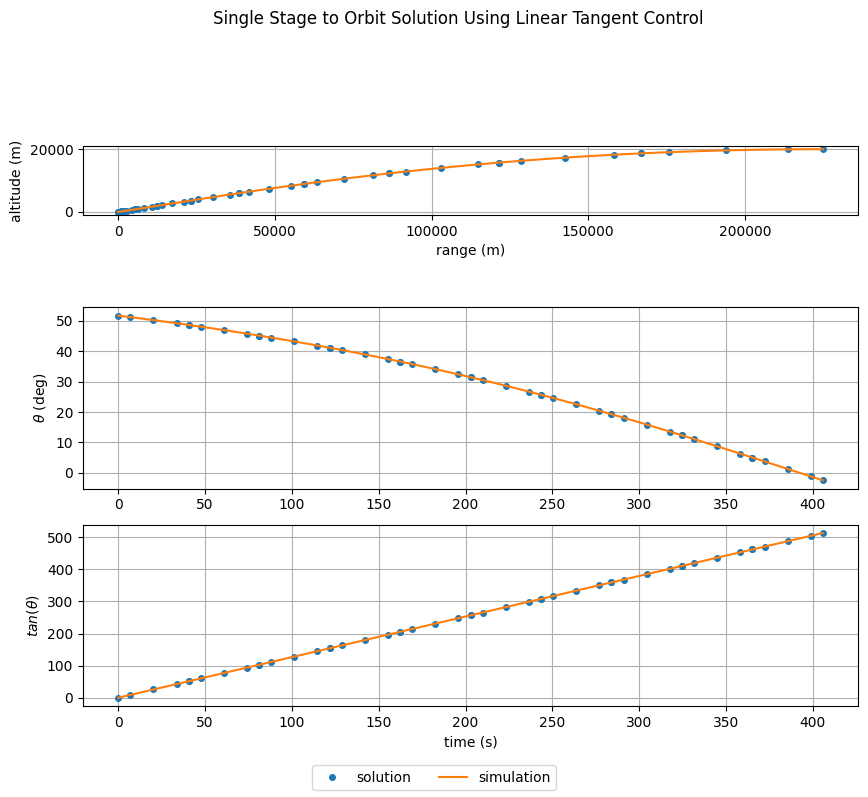

In [ ]:
sol = om.CaseReader('/content/problem70_out/dymos_solution.db').get_case('final')
sim = om.CaseReader('/content/problem70_out/traj_simulation_23_out/dymos_simulation.db').get_case('final')

fig, [traj_ax, control_ax, param_ax] = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

traj_ax.plot(sol.get_val('traj.phase0.timeseries.x'),
             sol.get_val('traj.phase0.timeseries.y'),
             marker='o',
             ms=4,
             linestyle='None',
             label='solution')

traj_ax.plot(sim.get_val('traj.phase0.timeseries.x'),
             sim.get_val('traj.phase0.timeseries.y'),
             marker=None,
             linestyle='-',
             label='simulation')

traj_ax.set_xlabel('range (m)')
traj_ax.set_ylabel('altitude (m)')
traj_ax.set_aspect('equal')
traj_ax.grid(True)

control_ax.plot(sol.get_val('traj.phase0.timeseries.time'),
             sol.get_val('traj.phase0.timeseries.theta'),
             marker='o',
             ms=4,
             linestyle='None')

control_ax.plot(sim.get_val('traj.phase0.timeseries.time'),
             sim.get_val('traj.phase0.timeseries.theta'),
             linestyle='-',
             marker=None)

control_ax.set_ylabel(r'$\theta$ (deg)')
control_ax.grid(True)

a = sol.get_val('traj.phase0.parameters:a_ctrl')
b = sol.get_val('traj.phase0.parameters:b_ctrl')
t = sol.get_val('traj.phase0.timeseries.time_phase')
tan_theta_sol = a + b * t

a = sim.get_val('traj.phase0.parameters:a_ctrl')
b = sim.get_val('traj.phase0.parameters:b_ctrl')
t = sim.get_val('traj.phase0.timeseries.time_phase')
tan_theta_sim = a + b * t

param_ax.plot(sol.get_val('traj.phase0.timeseries.time'),
             tan_theta_sol,
             marker='o',
             ms=4,
             linestyle='None')

param_ax.plot(sim.get_val('traj.phase0.timeseries.time'),
             tan_theta_sim,
             linestyle='-',
             marker=None)

param_ax.set_xlabel('time (s)')
param_ax.set_ylabel(r'$tan(\theta)$')
param_ax.grid(True)

plt.suptitle('Single Stage to Orbit Solution Using Linear Tangent Control')
fig.legend(loc='lower center', ncol=2)

plt.show()